In [68]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
# Placeholder params
# -- None: this dimension will be the number of images in the mini-batch. It will be known at training time.
# -- 28, 28, 1: our images are 28x28 pixels x 1 value per pixel (grayscale). 
#        The last number would be 3 for color images and is not really necessary here.
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

# Weights
W = tf.Variable(tf.zeros([784, 10]))
# Biases
b = tf.Variable(tf.zeros([10]))

In [4]:
init = tf.global_variables_initializer()

# The 1-layer NN to train

In [5]:
# 1. Reshape -- flatten 28x28 pixels to a 784 vector
# 2. Matrix Multiply the result with the Weights Matrix
# 3. Add biases to the result
# 4. The overall result is fed to SoftMax to find the strongest signal
Y = tf.nn.softmax(tf.matmul(tf.reshape(X, [-1, 784]), W) + b)

# Placeholder for training labels
Y_ = tf.placeholder(tf.float32, [None, 10])

# Cross Entropy

#### Loss Function to be minimized
1. Multiply Correct labels by log of Predicted labels
2. Sum all elements in the vector
3. Negate the result

##### negative SUM ( (CorrectLabels) * log(PredictedLabels) )

In [6]:
cross_entropy = -tf.reduce_sum(Y_ * tf.log(Y))

In [7]:
# Percent of correct predictions
is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))

# https://www.tensorflow.org/api_docs/python/tf/reduce_mean
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# Gradient Descent 

Use Gradient Descent as the optimizer with a learning rate of 0.003

#### Use Cross Entropy as the loss function to minimize

* Computes the partial derivatives of the loss function relatively to all the weights and all the biases
* The gradient is then used to update the weights and biases

In [8]:
learning_rate = 0.003

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_step = optimizer.minimize(cross_entropy)

In [40]:
def plot_results(accuracy_data, train_loss, test_loss):
    plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
    fig = plt.figure()

    ax1 = fig.add_subplot(221)
    ax1.plot(range(len(accuracy_data)), accuracy_data, '-')
    ax1.title.set_text('Accuracy')
    plt.grid()

    norm_loss = [x/100 for x in test_loss]
    ax2 = fig.add_subplot(222)
    ax2.plot(range(len(train_loss)), train_loss, '-', color='blue')
    ax2.plot(range(len(norm_loss)), norm_loss, '-', color='red')
    ax2.title.set_text('Loss')
    plt.grid()

    plt.show()

# Train the Model

In [83]:
def train_model(training_step, acc, ce, iterations=5000, variable_learning_rate=False):
    acc_points, test_loss, training_loss = [], [], []
    
    # Get MNIST test data
    test_data={X: mnist.test.images, Y_: mnist.test.labels}
    
    if variable_learning_rate:
        # Set decaying learning rate
        max_learning_rate = 0.003
        min_learning_rate = 0.0001
        diff_lr = max_learning_rate - min_learning_rate
        lr_range = min_learning_rate + diff_lr

        decay_speed = 2000.0 # 0.003-0.0001-2000=>0.9826 done in 5000 iterations

    
    with tf.Session() as sess:
        sess.run(init)

        for i in range(iterations):
            # Get next training batch
            batch_X, batch_Y = mnist.train.next_batch(100)

            
            if variable_learning_rate:
                learning_rate = lr_range * math.exp(-i/decay_speed)
                train_data = {X: batch_X, Y_: batch_Y, lr: learning_rate}
            else:
                train_data = {X: batch_X, Y_: batch_Y}

            # Backpropagation training step
            sess.run(training_step, feed_dict=train_data)
            if (i % 10) == 0:
                # Get accuracy and loss with training data
                _, c = sess.run([acc, ce], feed_dict=train_data)
                training_loss.append(c)

                # Get accuracy and loss with test data
                a, c = sess.run([acc, ce], feed_dict=test_data)
                acc_points.append(a)
                test_loss.append(c)

        a, c = sess.run([acc, ce], feed_dict=test_data)
        acc_points.append(a)
        test_loss.append(c)

    return ((a, c), acc_points, test_loss, training_loss)

# Train Single Layer NN

accuracy:0.9247 loss: 2712.47


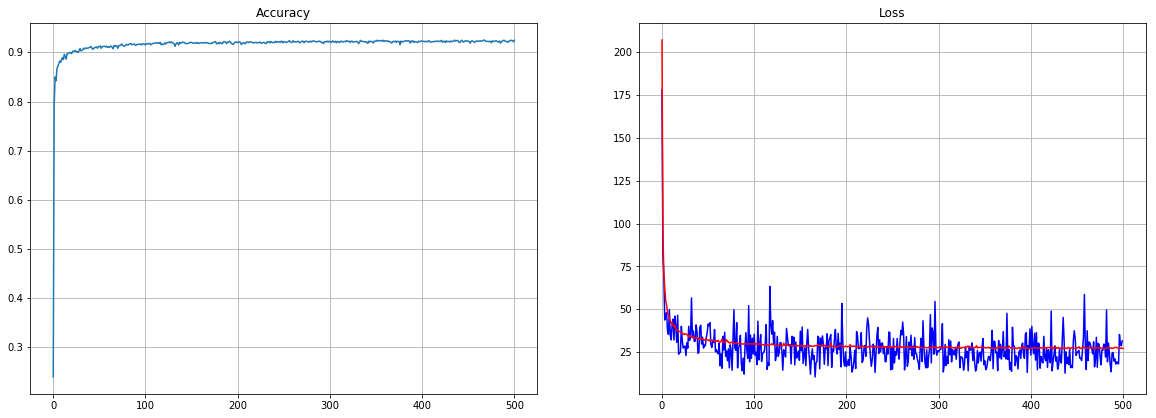

In [14]:
d, acc, test_loss, train_loss = train_model(train_step, accuracy, cross_entropy)

print("accuracy:" + str(d[0]) + " loss: " + str(d[1]))
plot_results(acc, train_loss, test_loss)

# Add more layers

In [70]:
# Initialize weights with random values between -2*stddev and +2*stddev
W1 = tf.Variable(tf.truncated_normal([28*28, 200], stddev=0.1))
B1 = tf.Variable(tf.zeros([200]))
W2 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B2 = tf.Variable(tf.zeros([10]))

In [71]:
XX = tf.reshape(X, [-1, 28*28])
#Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)
Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)

# Fix NaN issues
#Y  = tf.nn.softmax(tf.matmul(Y1, W2) + B2)
Ylogits = tf.matmul(Y1, W2) + B2
Y  = tf.nn.softmax(Ylogits)

In [81]:
#loss_fn = -tf.reduce_sum(Y_ * tf.log(Y))
loss_fn = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
loss_fn = tf.reduce_mean(loss_fn)*100

is_correct = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
                                  
learning_rate = 0.003
adam_train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss_fn)

# Learning rate placeholder
lr = tf.placeholder(tf.float32)

init = tf.global_variables_initializer()

# Re-Train the Model

accuracy:0.9787 loss: 8.47991


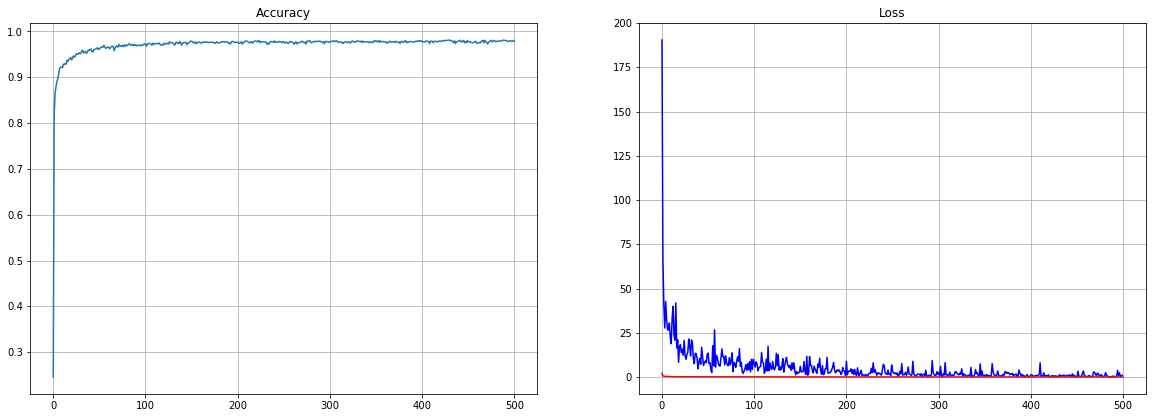

In [84]:
d, acc, test_loss, train_loss = train_model(adam_train_step, accuracy, loss_fn, variable_learning_rate=True)

print("accuracy:" + str(d[0]) + " loss: " + str(d[1]))
plot_results(acc, train_loss, test_loss)